In [1]:
import time
import json
import random
import numpy as np
from glob import glob
import matplotlib as mpl
from copy import deepcopy
from smol.io import load_work
from smol.moca import Sampler
from smol.moca import Ensemble
from smol.cofe.space import Vacancy
from smol.moca.sampler.mcusher import Tableflip
from pymatgen.core.sites import Species
from pymatgen.core.structure import Structure
from pymatgen.transformations.standard_transformations \
import (OxidationStateDecorationTransformation, \
        OrderDisorderedStructureTransformation)
from monty.serialization import dumpfn, loadfn
from smol.moca.sampler.container import SampleContainer
from matplotlib import pyplot as plt

## 0. Functions

In [2]:
# For sanity check

def get_dim_ids_by_sublattice(bits):
    """Get the component index of each species in vector n.

    Args:
        bits(List[List[Specie|Vacancy|Element]]):
           Species on each sub-lattice.
    Returns:
        Component index of each species on each sublattice in vector n:
           List[List[int]]
    """
    dim_ids = []
    dim_id = 0
    for species in bits:
        dim_ids.append(list(range(dim_id, dim_id + len(species))))
        dim_id += len(species)
    return dim_ids


def flip_vec_to_reaction(u, bits):
    """Convert flip direction into a reaction formula in string.

    This function is for easy interpretation of flip directions.
    Args:
        u(1D ArrayLike[int]):
            The flip vector in number change of species.
        bits(List[List[Specie|DummySpecie|Element|Vacancy]]):
            Species on all sub-lattices.
    Return:
        Reaction formulas: str.
    """
    u = np.array(u, dtype=int)
    dim_ids = get_dim_ids_by_sublattice(bits)

    from_strs = []
    to_strs = []

    for sl_id, (sl_species, sl_dims) in enumerate(zip(bits, dim_ids)):
        for specie, dim in zip(sl_species, sl_dims):
            if u[dim] < 0:
                from_strs.append('{} {}({})'
                                 .format(-u[dim], str(specie), sl_id))
            elif u[dim] > 0:
                to_strs.append('{} {}({})'
                               .format(u[dim], str(specie), sl_id))

    from_str = ' + '.join(from_strs)
    to_str = ' + '.join(to_strs)
    return from_str + ' -> ' + to_str


def set_rc_params():
    """
    General params for plot.
    """
    params = {'axes.linewidth': 1.5,
              'axes.unicode_minus': False,
              'figure.dpi': 300,
              'font.size': 25,
              'legend.frameon': False,
              'legend.handletextpad': 0.4,
              'legend.handlelength': 1,
              'legend.fontsize': 10,
              'lines.markeredgewidth': 4,
              'lines.linewidth': 3,
              'lines.markersize': 15,
              'mathtext.default': 'regular',
              'savefig.bbox': 'tight',
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'xtick.major.size': 5,
              'xtick.minor.size': 3,
              'ytick.major.size': 5,
              'ytick.minor.size': 3,
              'xtick.major.width': 1,
              'xtick.minor.width': 0.5,
              'ytick.major.width': 1,
              'ytick.minor.width': 0.5,
              'xtick.top': True,
              'ytick.right': True,
              'axes.edgecolor': 'black',
              'legend.fancybox': True,
              'figure.figsize': [8, 6]}
    for p in params:
        mpl.rcParams[p] = params[p]

In [3]:
# Trajectory retriever
# Finished functions

def read_json(fjson):
    with open(fjson) as f:
        return json.load(f)


def write_json(d, fjson):
    with open(fjson, 'w') as f:
        json.dump(d, f)
    return d


def get_data_from_hdf5(saved_path):
    
    return


def get_data_from_nps(saved_path):
    
    return


def get_discard_length():
    
    # Need low temperature run data to test
    
    return


def get_sampling_efficiency(energies, discard_length, sampling_length):
    """
    Args:
        energies: NumPy array. Sampled energy.
        discard_length: Int. Equilibrium length of the sample.
        sampling_length: Int. Sampling length to get sampling efficiency.
    Returns:
        tot_var: total variance of the entire sample.
        block_var: block variance.
        sampling_efficiency: Idealy 1.
    """
    blocks = []
    block_means = []
    start_position = discard_length
    tot_var = np.var(energies[discard_length:])

    while start_position + sampling_length < len(energies):
        blocks.append(energies[start_position : start_position + sampling_length])
        start_position += sampling_length

    for i in blocks:
        block_means.append(i.mean())
    block_var = np.var(block_means)
    sampling_efficiency = tot_var / sampling_length / block_var
    
    return tot_var, block_var, sampling_efficiency


def get_thin_trajectory(species_count, discard_length, thin_by):
    """
    Args:
        species_count: Dict. of counted number of species
        discard_length: Int. Equilibrium length of the sample.
        thin_by: Int. Thin by number.
    Returns:
        thin_trajectory: List of tuple (Ca2+, Na+). Thinned tracjectory
        average: Average value of ensemble.
    """
    # Assume that sampled from 5x5x6 size ensemble
    thin_trajectory = []
    discarded_na = species_count['Na+'][discard_length:]
    discarded_ca = species_count['Ca2+'][discard_length:]
    ca_total = 0
    na_total = 0
    count = 0
    for i, j in enumerate(discarded_na):
        if i % thin_by == 0:
            thin_trajectory.append((discarded_ca[i]/300, j/300))
        count += 1
        ca_total += discarded_ca[i]/300
        na_total += j/300
    ca_average = ca_total / count
    na_average = na_total / count
    
    return thin_trajectory, (ca_average, na_average)


def get_all_trajectories(saved_dir, discard_length, thin_by):
    
    traj_data = {}
    species_count_list = []
    saved_list = glob(saved_dir + "/*")
    for i in saved_list:
        if "species_count" in i:
            species_count_list.append(i)
    for j in species_count_list:
        spec_species_count = read_json(j)
        spec_species_count = json.loads(spec_species_count)
        thin_trajectory, average = get_thin_trajectory(spec_species_count, discard_length, thin_by)
        # Need to automate key generation
        key = '_'.join(j.split("/")[-1].split("_")[:2])
        traj_data[key] = {}
        traj_data[key]['trajectory'] = thin_trajectory
        traj_data[key]['average'] = average
    
    return traj_data

## 1. Load data from cluster expansion fitting & Generate Ensemble
Note: For the details of fitting, refer to groupCE_CaNaVP

In [4]:
work = load_work('/global/scratch/users/yychoi94/CaNaVP/data/final_data/ce/final_canvp_ce.mson')
expansion = work['ClusterExpansion']
wrangler = work['StructureWrangler']
print("{} Non-zero ECIS over {} cluster ECIS".format(np.count_nonzero(expansion.coefs), len(expansion.coefs)))

103 Non-zero ECIS over 629 cluster ECIS


## 2. Set Basic variables. 

In [5]:
# Atoms.
na = Species('Na', 1)
ca = Species('Ca', 2)
v3 = Species('V', 3)
v4 = Species('V', 4)
v5 = Species('V', 5)
vac = Vacancy()

# Supercell matrix
sc_matrix = np.array([[5, 0, 0],
                      [0, 5, 0],
                      [0, 0, 6]])

# Relative chemical potentials
chemical_potentials = {'Na+':0, 'Ca2+': 0, 'Vacancy': 0,
                       'V3+': 0, 'V4+': 0, 'V5+': 0}

## 3. Load ensemble.

In [6]:
ensemble_path = '/global/scratch/users/yychoi94/CaNaVP/data/final_data/gcmc/final_canvp_ensemble_1201.mson'
ensemble = loadfn(ensemble_path)
# dumpfn(ensemble, ensemble_path)

In [7]:
for sublattice in ensemble.sublattices:
    print(sublattice.species)

(Species O2-,)
(Species Na+, Species Ca2+, Vacancy vacA0+)
(Species V3+, Species V4+, Species V5+)
(Species P5+,)


In [8]:
# Specific flip table based on saved ensemble.
flip_table = np.array([[0,  -1,  0,  1,  -1,  1,  0,  0],
                       [0,  -1,  0,  1,  0,  -1,  1,  0],
                       [0,  0,  -1,  1,  -1,  0,  1,  0],
                       [0,  -2,  1,  1,  0,  0,  0,  0]])

In [9]:
start = time.time()
sampler = Sampler.from_ensemble(ensemble, step_type="tableflip",
                                temperature=2000, optimize_basis=False, flip_table=flip_table)

print(f"Sampling information: {sampler.samples.metadata}")
end = time.time()
print(f"{end-start}s for initialization.")

/global/home/users/yychoi94/miniconda3/envs/cn-sgmc/lib/python3.9/site-packages/smol/moca/sampler/mcusher.py:358: UserWarning: Current occupancy violates compspace constraints! Are you initializing trace?
  warnings.warn("Current occupancy violates compspace constraints! "


Sampling information: {'kernel': 'Metropolis', 'step': 'tableflip', 'chemical_potentials': {Species Na+: 0, Species Ca2+: 0, Vacancy vacA0+: 0, Species V3+: 0, Species V4+: 0, Species V5+: 0}, 'seeds': [101881326960223263891983305517603298675]}
0.820220947265625s for initialization.


## 4. Retrieve trajectory

In [10]:
set_rc_params()

In [12]:
save_dir = "/global/scratch/users/yychoi94/CaNaVP_gcMC/300Na1to3/data"
saved_list = glob(save_dir + "/*")
tot_cation_site = round(np.linalg.det(ensemble.processor.supercell_matrix)) * 8

In [42]:
test_traj_data = get_all_trajectories(save_dir, 50000, 5000)

In [38]:
def get_vc_data(traj_data, cation='Na'):
    
    # Option: 
    voltages, cations = [], []
    for key in traj_data:
        if cation == 'Na':
            chempo = float(key.split('_')[-1])
            # Na ev/atom is from mp-1186081
            voltage = (-1.3225 - chempo)
            cations.append(test_traj_data[key]['average'][1])
        elif cation == 'Ca':
            chempo = float(key.split('_')[0])
            # Ca ev/atom is from mp-
            voltage = (-2.0056 - chempo) / 2
            cations.append(test_traj_data[key]['average'][0])
        voltages.append(voltage)
    sorted_voltages = [x for _, x in sorted(zip(cations, voltages))]
    cations.sort()
    
    return cations, sorted_voltages

def plot_vc_data(cations, sorted_voltages):
    
    plt.scatter(cations, sorted_voltages, color='tab:blue', edgecolors='black', linewidth=1)
    plt.plot(cations, sorted_voltages, linestyle='--', color='tab:blue')
    plt.axhline(3.29, xmin=1.25/3.5, xmax=2.25/3.5, linestyle='--',linewidth=1, color='r')
    plt.axhline(3.23, xmin=2.25/3.5, xmax=3.25/3.5, linestyle='--',linewidth=1, color='r')
    plt.axvline(2, ymin=3.23/5, ymax=3.29/5, linestyle='--',linewidth=1, color='r')
    plt.title("Na only Voltage-Capacity curve", fontsize=20, y=1.02)
    plt.xlabel("<Na> in $V_{2}(PO_{4})_{3}$")
    plt.ylabel("Voltage (V)")
    plt.ylim(0, 5)
    plt.xlim(-0.25, 3.25)
    
    return

def energy_plot():
    
    # This is to check energy convergence.
    
    
    return

-41943.9974770984


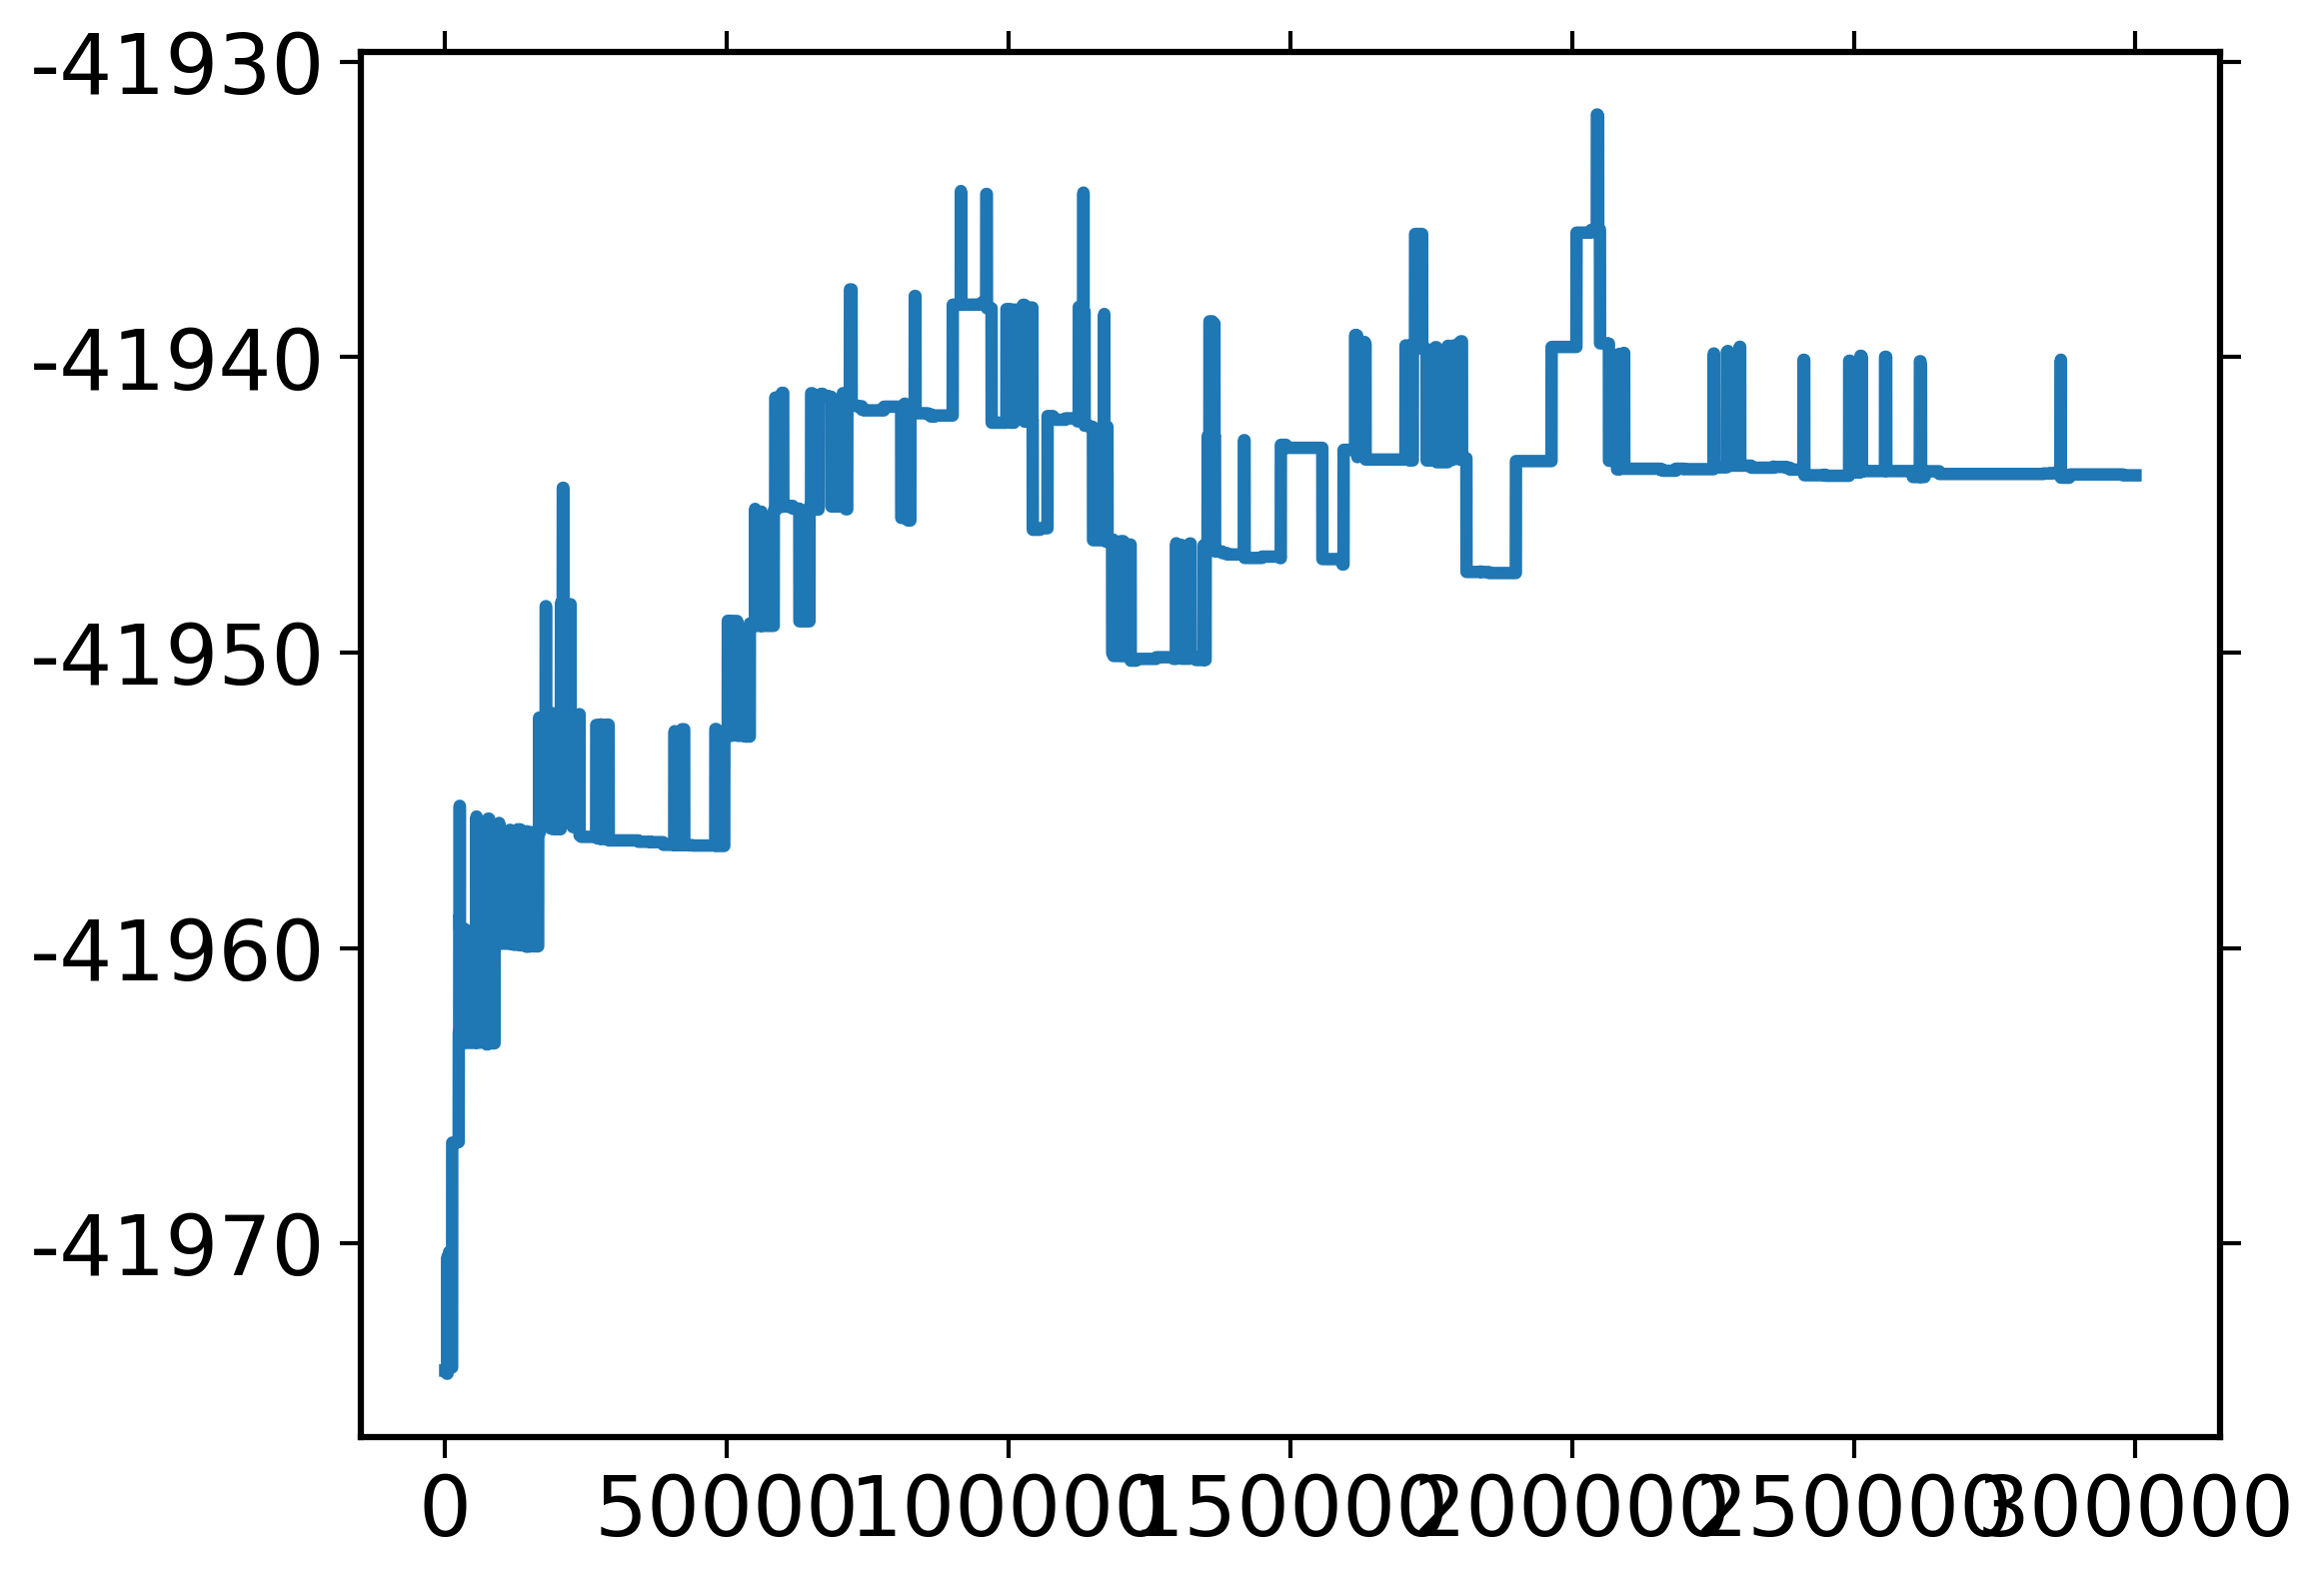

In [50]:
energy_dir = '/global/scratch/users/yychoi94/CaNaVP_gcMC/300Na3to1/data/-30.0_-3.73737_energy.npy'
energies = np.load(energy_dir)
plt.plot(energies)
print(energies[-1])

-41635.266835307615


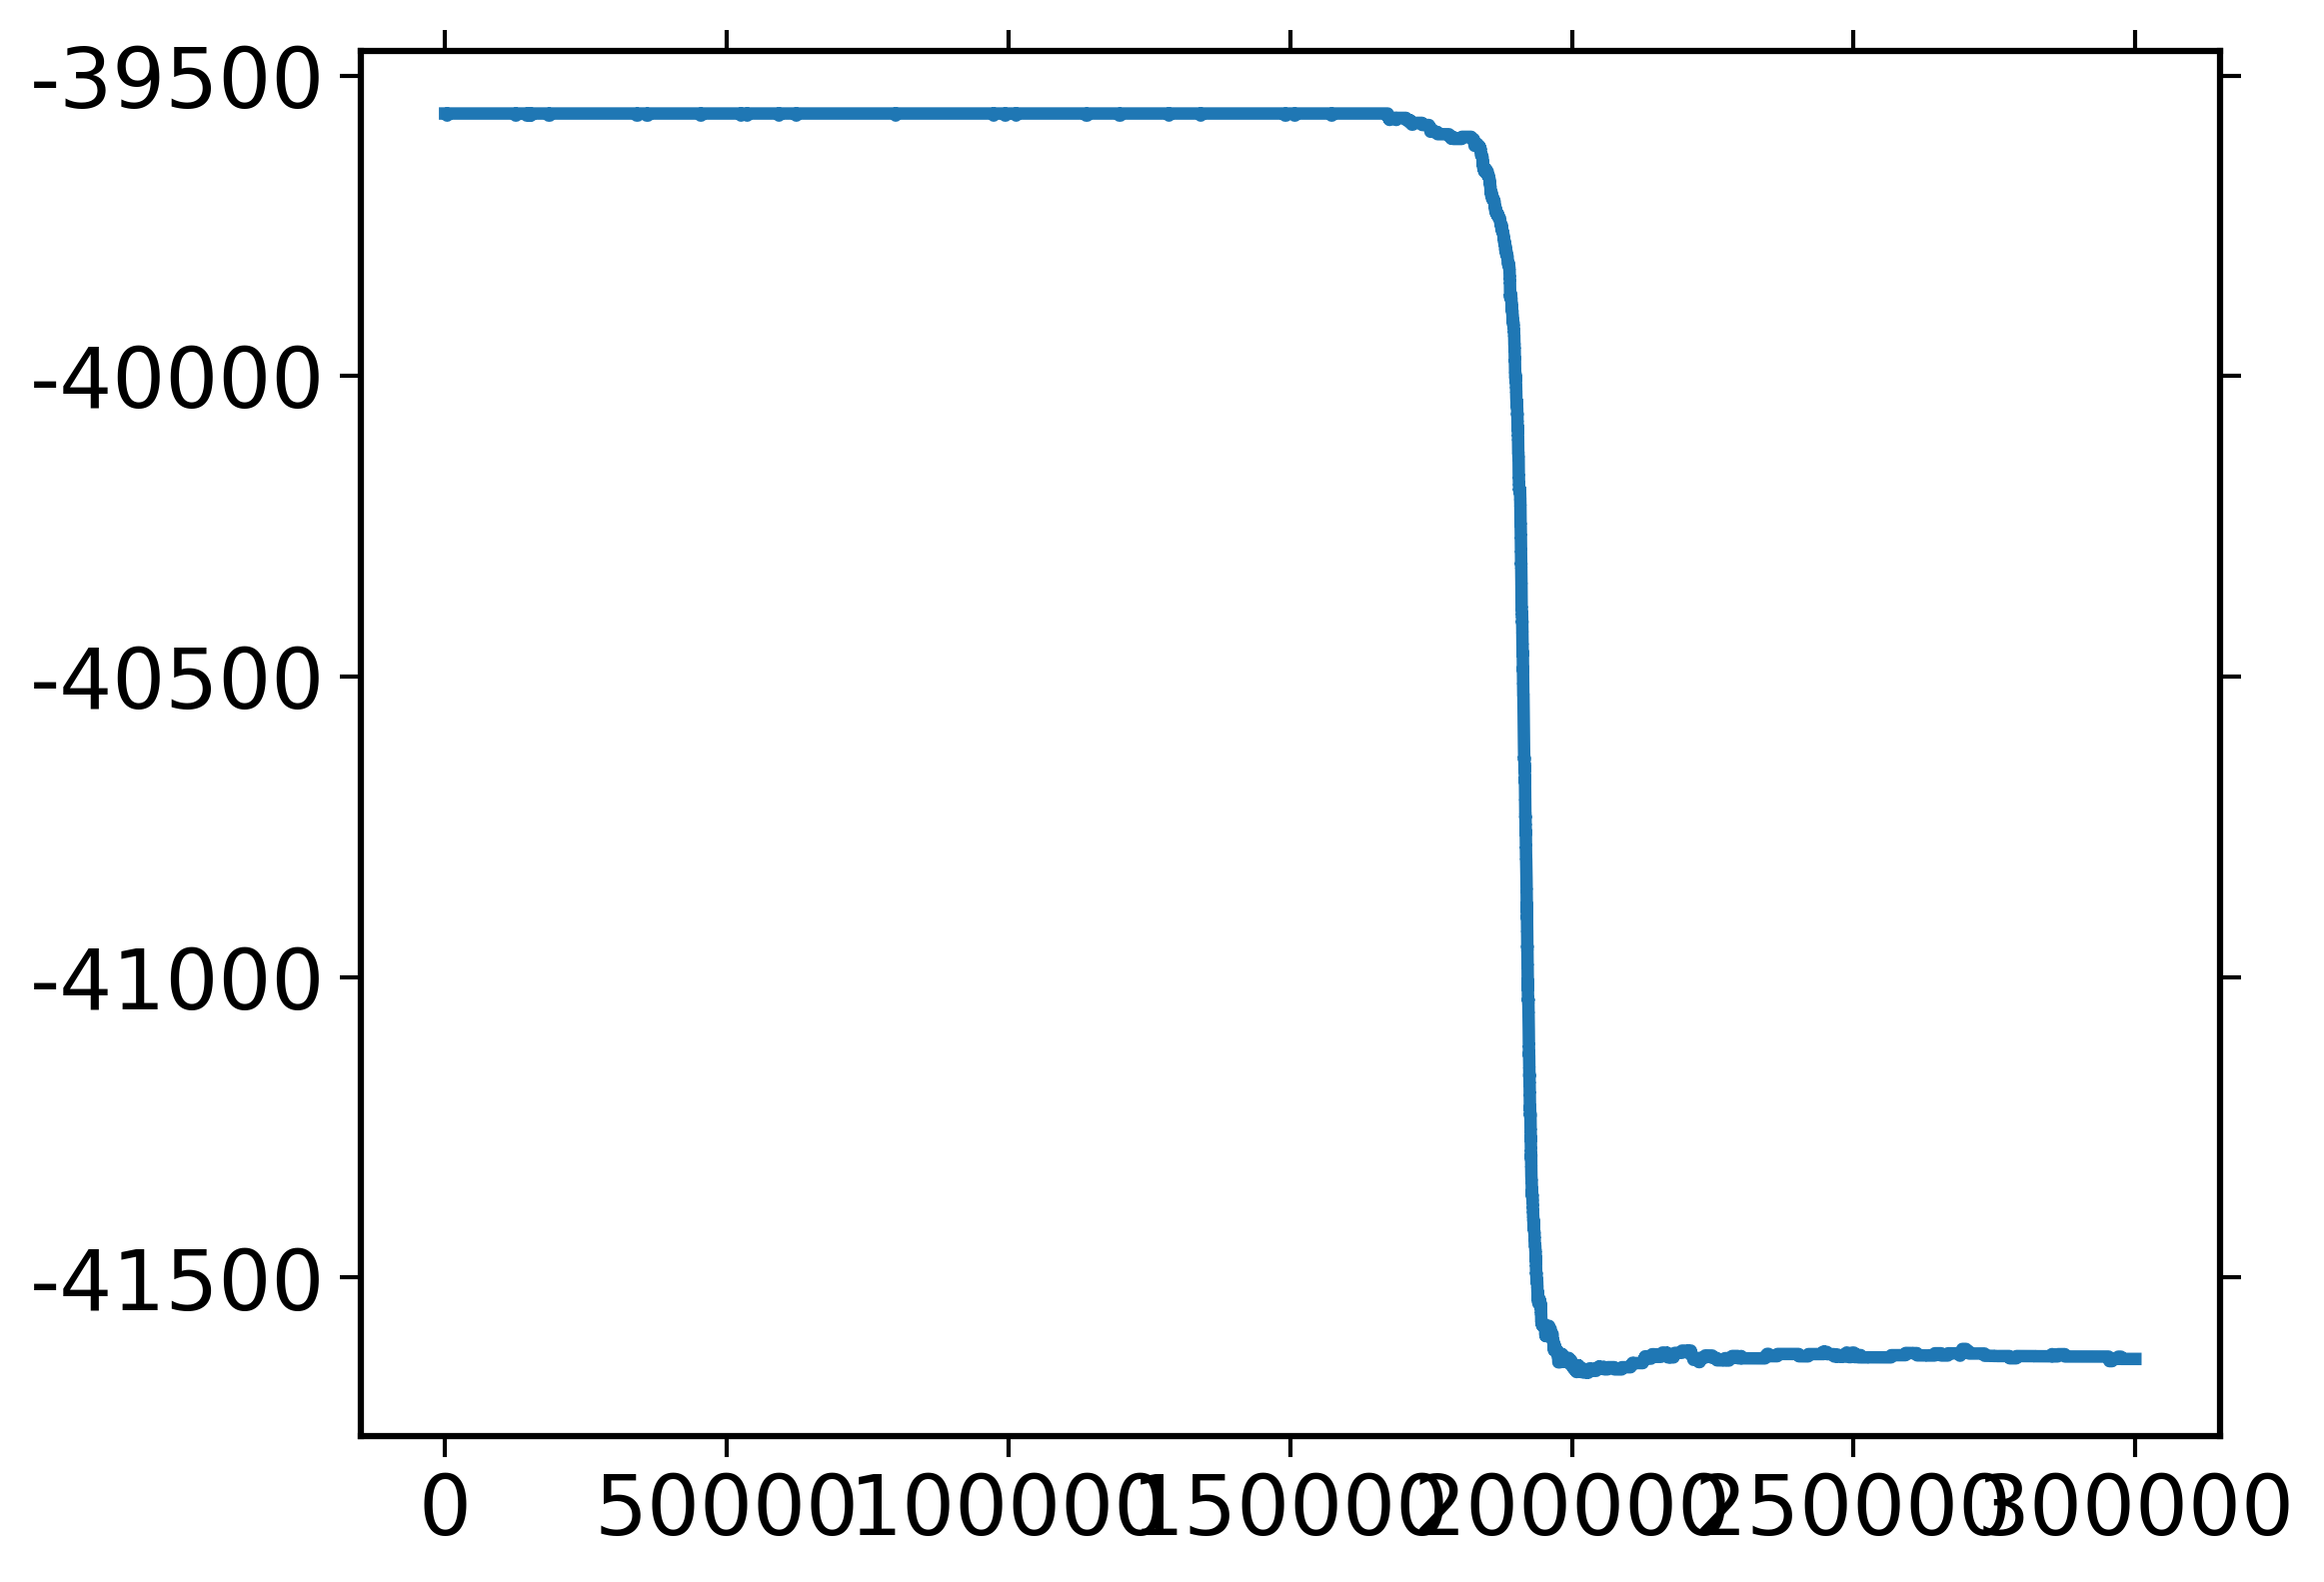

In [51]:
energy_dir = '/global/scratch/users/yychoi94/CaNaVP_gcMC/300Na1to3/data/-30.0_-3.73737_energy.npy'
energies = np.load(energy_dir)
plt.plot(energies)
print(energies[-1])

In [43]:
cations, sorted_voltages = get_vc_data(test_traj_data, cation='Na')

In [48]:
cations.index(1.7408126933342976)

63

In [49]:
sorted_voltages[63]

2.4148699999999996

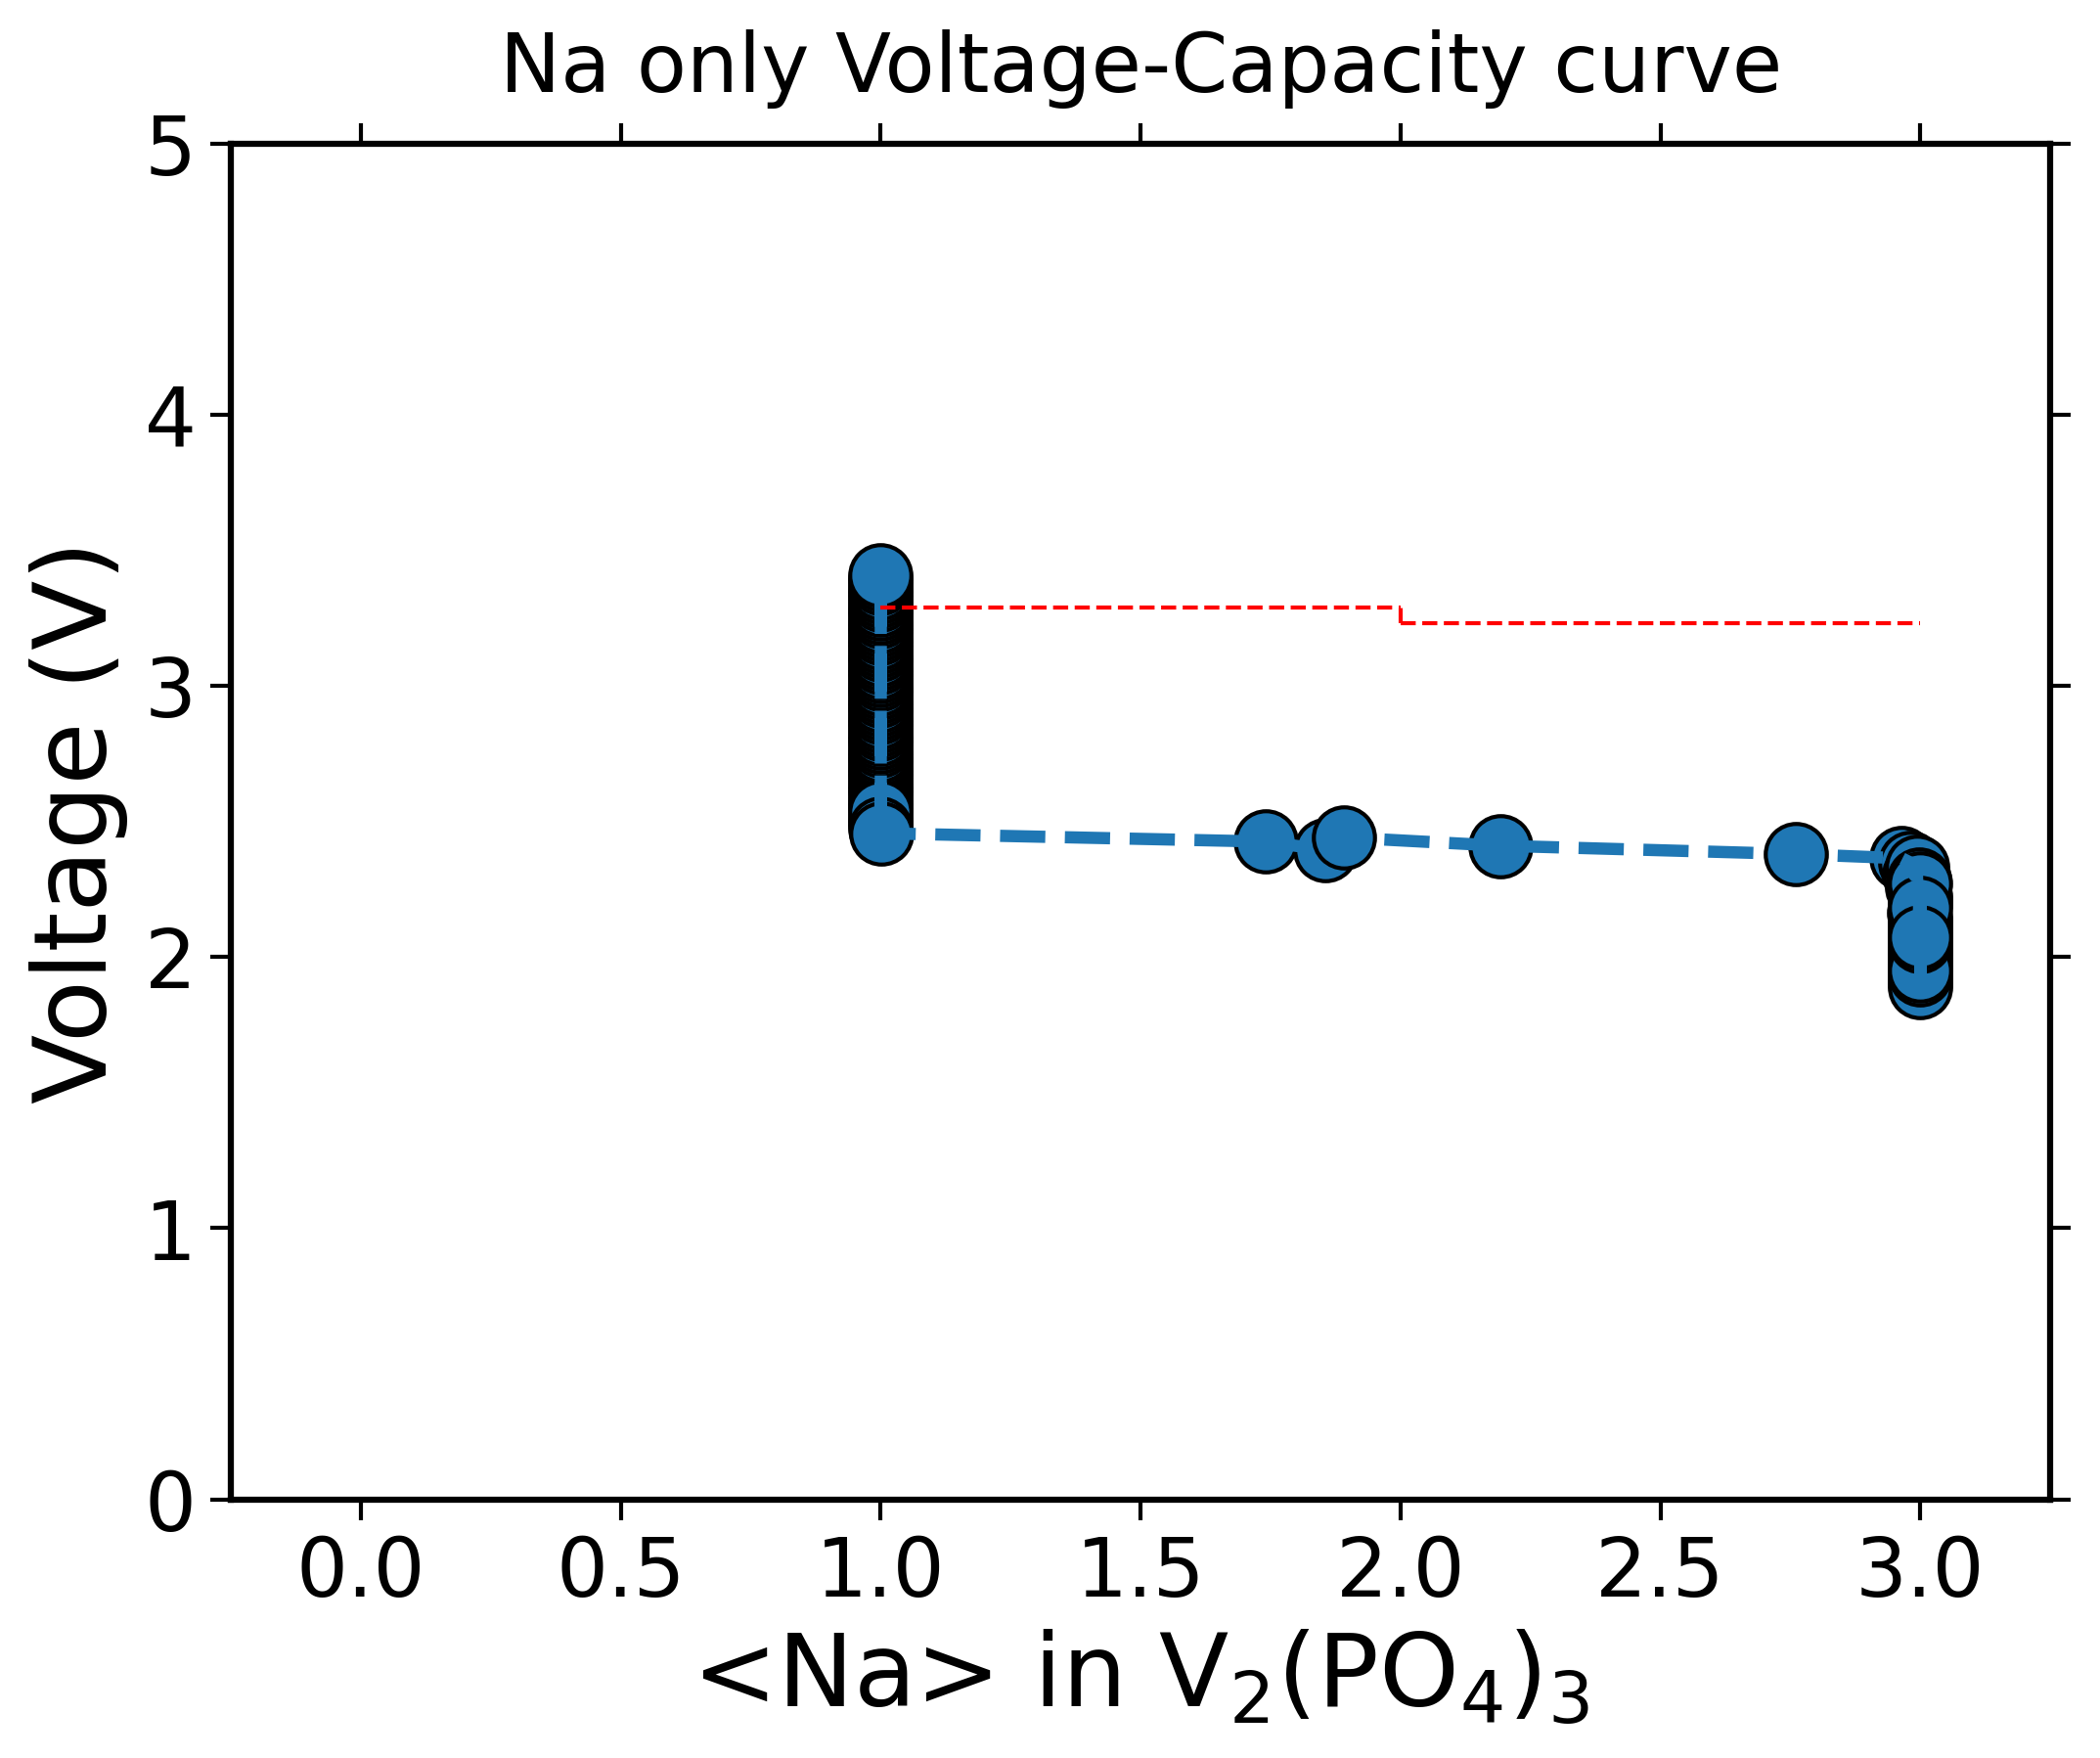

In [26]:
plot_vc_data(cations, sorted_voltages)

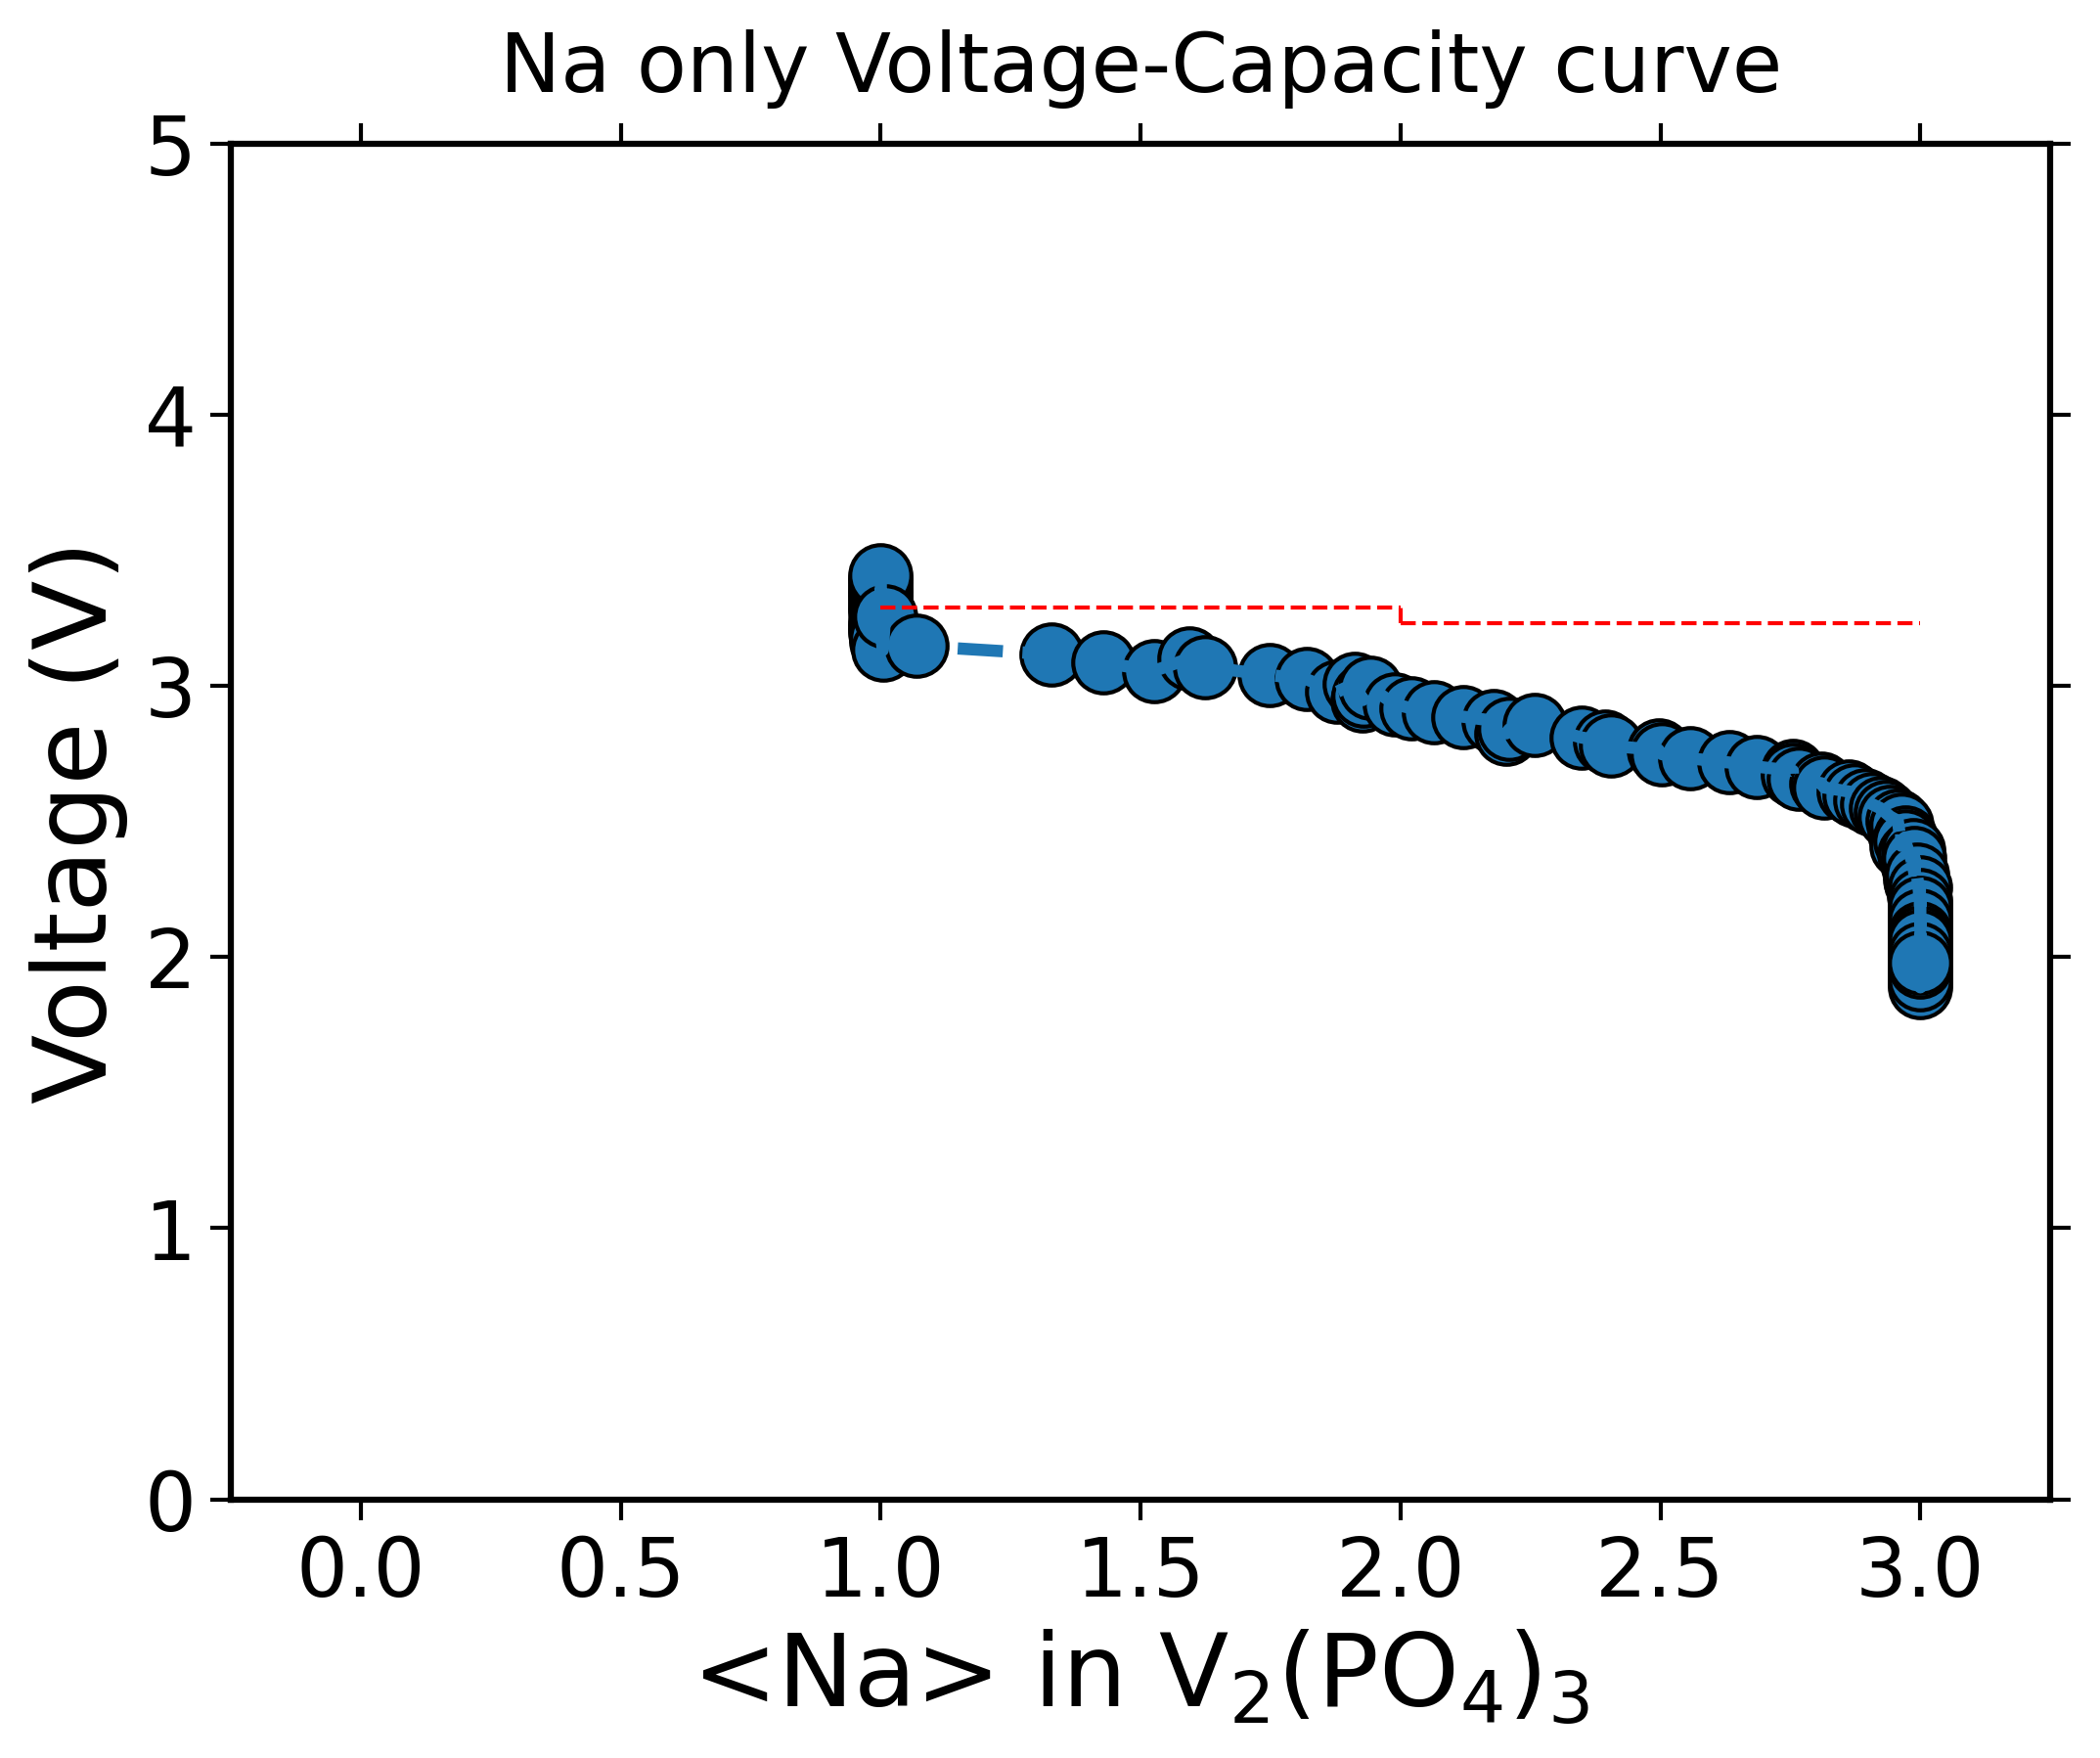

In [30]:
plot_vc_data(cations, sorted_voltages)

In [75]:
- sorted_voltages[38] -1.3122

-4.72

In [73]:
- sorted_voltages[99] -1.3122

-3.2

## Retrieve Structure

In [81]:
occu_dir = '/global/scratch/users/yychoi94/CaNaVP_gcMC/300K_556_30_6020/data/-30.0_-4.72_occupancy.npz'
occupancies = np.load(occu_dir)['o']
final_structure = ensemble.processor.structure_from_occupancy(occupancies[-1])
final_structure.sort()

In [85]:
final_structure.to('POSCAR', './300_Na1_POSCAR')
np.save('./300_Na1_occu.npy', occupancies[-1])

In [52]:
from mp_api.client import MPRester

In [53]:
with MPRester(api_key='dPcAQJZ6y1NZidGuvTerIPPFXHtsOb3E') as mpr:

    # for a single material
    thermo_doc = mpr.get_entry_by_material_id('mp-776557')

Retrieving ThermoDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5924.16it/s]


In [54]:
thermo_doc

[mp-776557-GGA+U ComputedStructureEntry - Na6 V4 P6 O24 (Na3V2(PO4)3)
 Energy (Uncorrected)     = -279.3576 eV (-6.9839  eV/atom)
 Correction               = -23.2880  eV (-0.5822  eV/atom)
 Energy (Final)           = -302.6456 eV (-7.5661  eV/atom)
 Energy Adjustments:
   MP2020 anion correction (oxide): -16.4880  eV (-0.4122  eV/atom)
   MP2020 GGA/GGA+U mixing correction (V): -6.8000   eV (-0.1700  eV/atom)
 Parameters:
   potcar_spec            = [{'titel': 'PAW_PBE Na_pv 05Jan2001', 'hash': 'c71d0ed99a871c91fccae9347860d8ba'}, {'titel': 'PAW_PBE V_pv 07Sep2000', 'hash': '7f1297a2e1d963e2a4d81b61f85e4ded'}, {'titel': 'PAW_PBE P 17Jan2003', 'hash': '7dc3393307131ae67785a0cdacb61d5f'}, {'titel': 'PAW_PBE O 08Apr2002', 'hash': '7a25bc5b9a5393f46600a4939d357982'}]
   is_hubbard             = True
   hubbards               = {'Na': 0.0, 'V': 3.25, 'P': 0.0, 'O': 0.0}
   run_type               = GGA+U
 Data:
   oxide_type             = oxide
   aspherical             = True
   last_updat

In [55]:
with MPRester(api_key='dPcAQJZ6y1NZidGuvTerIPPFXHtsOb3E') as mpr:

    # for a single material
    thermo_doc = mpr.get_entry_by_material_id('mp-764171')

Retrieving ThermoDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7667.83it/s]


In [56]:
thermo_doc

[mp-764171-GGA+U ComputedStructureEntry - Na4 V8 P12 O48 (NaV2(PO4)3)
 Energy (Uncorrected)     = -521.8617 eV (-7.2481  eV/atom)
 Correction               = -46.5760  eV (-0.6469  eV/atom)
 Energy (Final)           = -568.4377 eV (-7.8950  eV/atom)
 Energy Adjustments:
   MP2020 anion correction (oxide): -32.9760  eV (-0.4580  eV/atom)
   MP2020 GGA/GGA+U mixing correction (V): -13.6000  eV (-0.1889  eV/atom)
 Parameters:
   potcar_spec            = [{'titel': 'PAW_PBE Na_pv 05Jan2001', 'hash': 'c71d0ed99a871c91fccae9347860d8ba'}, {'titel': 'PAW_PBE V_pv 07Sep2000', 'hash': '7f1297a2e1d963e2a4d81b61f85e4ded'}, {'titel': 'PAW_PBE P 17Jan2003', 'hash': '7dc3393307131ae67785a0cdacb61d5f'}, {'titel': 'PAW_PBE O 08Apr2002', 'hash': '7a25bc5b9a5393f46600a4939d357982'}]
   is_hubbard             = True
   hubbards               = {'Na': 0.0, 'V': 3.25, 'P': 0.0, 'O': 0.0}
   run_type               = GGA+U
 Data:
   oxide_type             = oxide
   aspherical             = True
   last_updat

In [58]:
type(thermo_doc[0])

pymatgen.entries.computed_entries.ComputedStructureEntry

In [59]:
specific_corrections = {'O':-0.687, 
                        'V': -1.7,
                        'Cr': -1.999,
                        'Mn': -1.668,
                        'Fe': -2.256,
                        'Co': -1.638,
                        'Ni': -2.541,
                        'W': -4.438,
                        'Mo': -3.202}

In [61]:
-0.687*48 + -1.7*8

-46.576

In [63]:
Na3 = -839.39494
Na1 = -791.56717
Na = -1.3225

In [64]:
corrected_Na3 = Na3 + specific_corrections['O'] * 72 + specific_corrections['V'] * 12
corrected_Na1 = Na1 + specific_corrections['O'] * 72 + specific_corrections['V'] * 12

In [68]:
((corrected_Na3 - corrected_Na1) / 6 - 2 * Na)/2


-2.663147499999999

In [69]:
((Na3 - Na1) / 6 - 2 * Na)/2


-2.663147499999999

## Test Na1 Frozen

-39563.29943683782


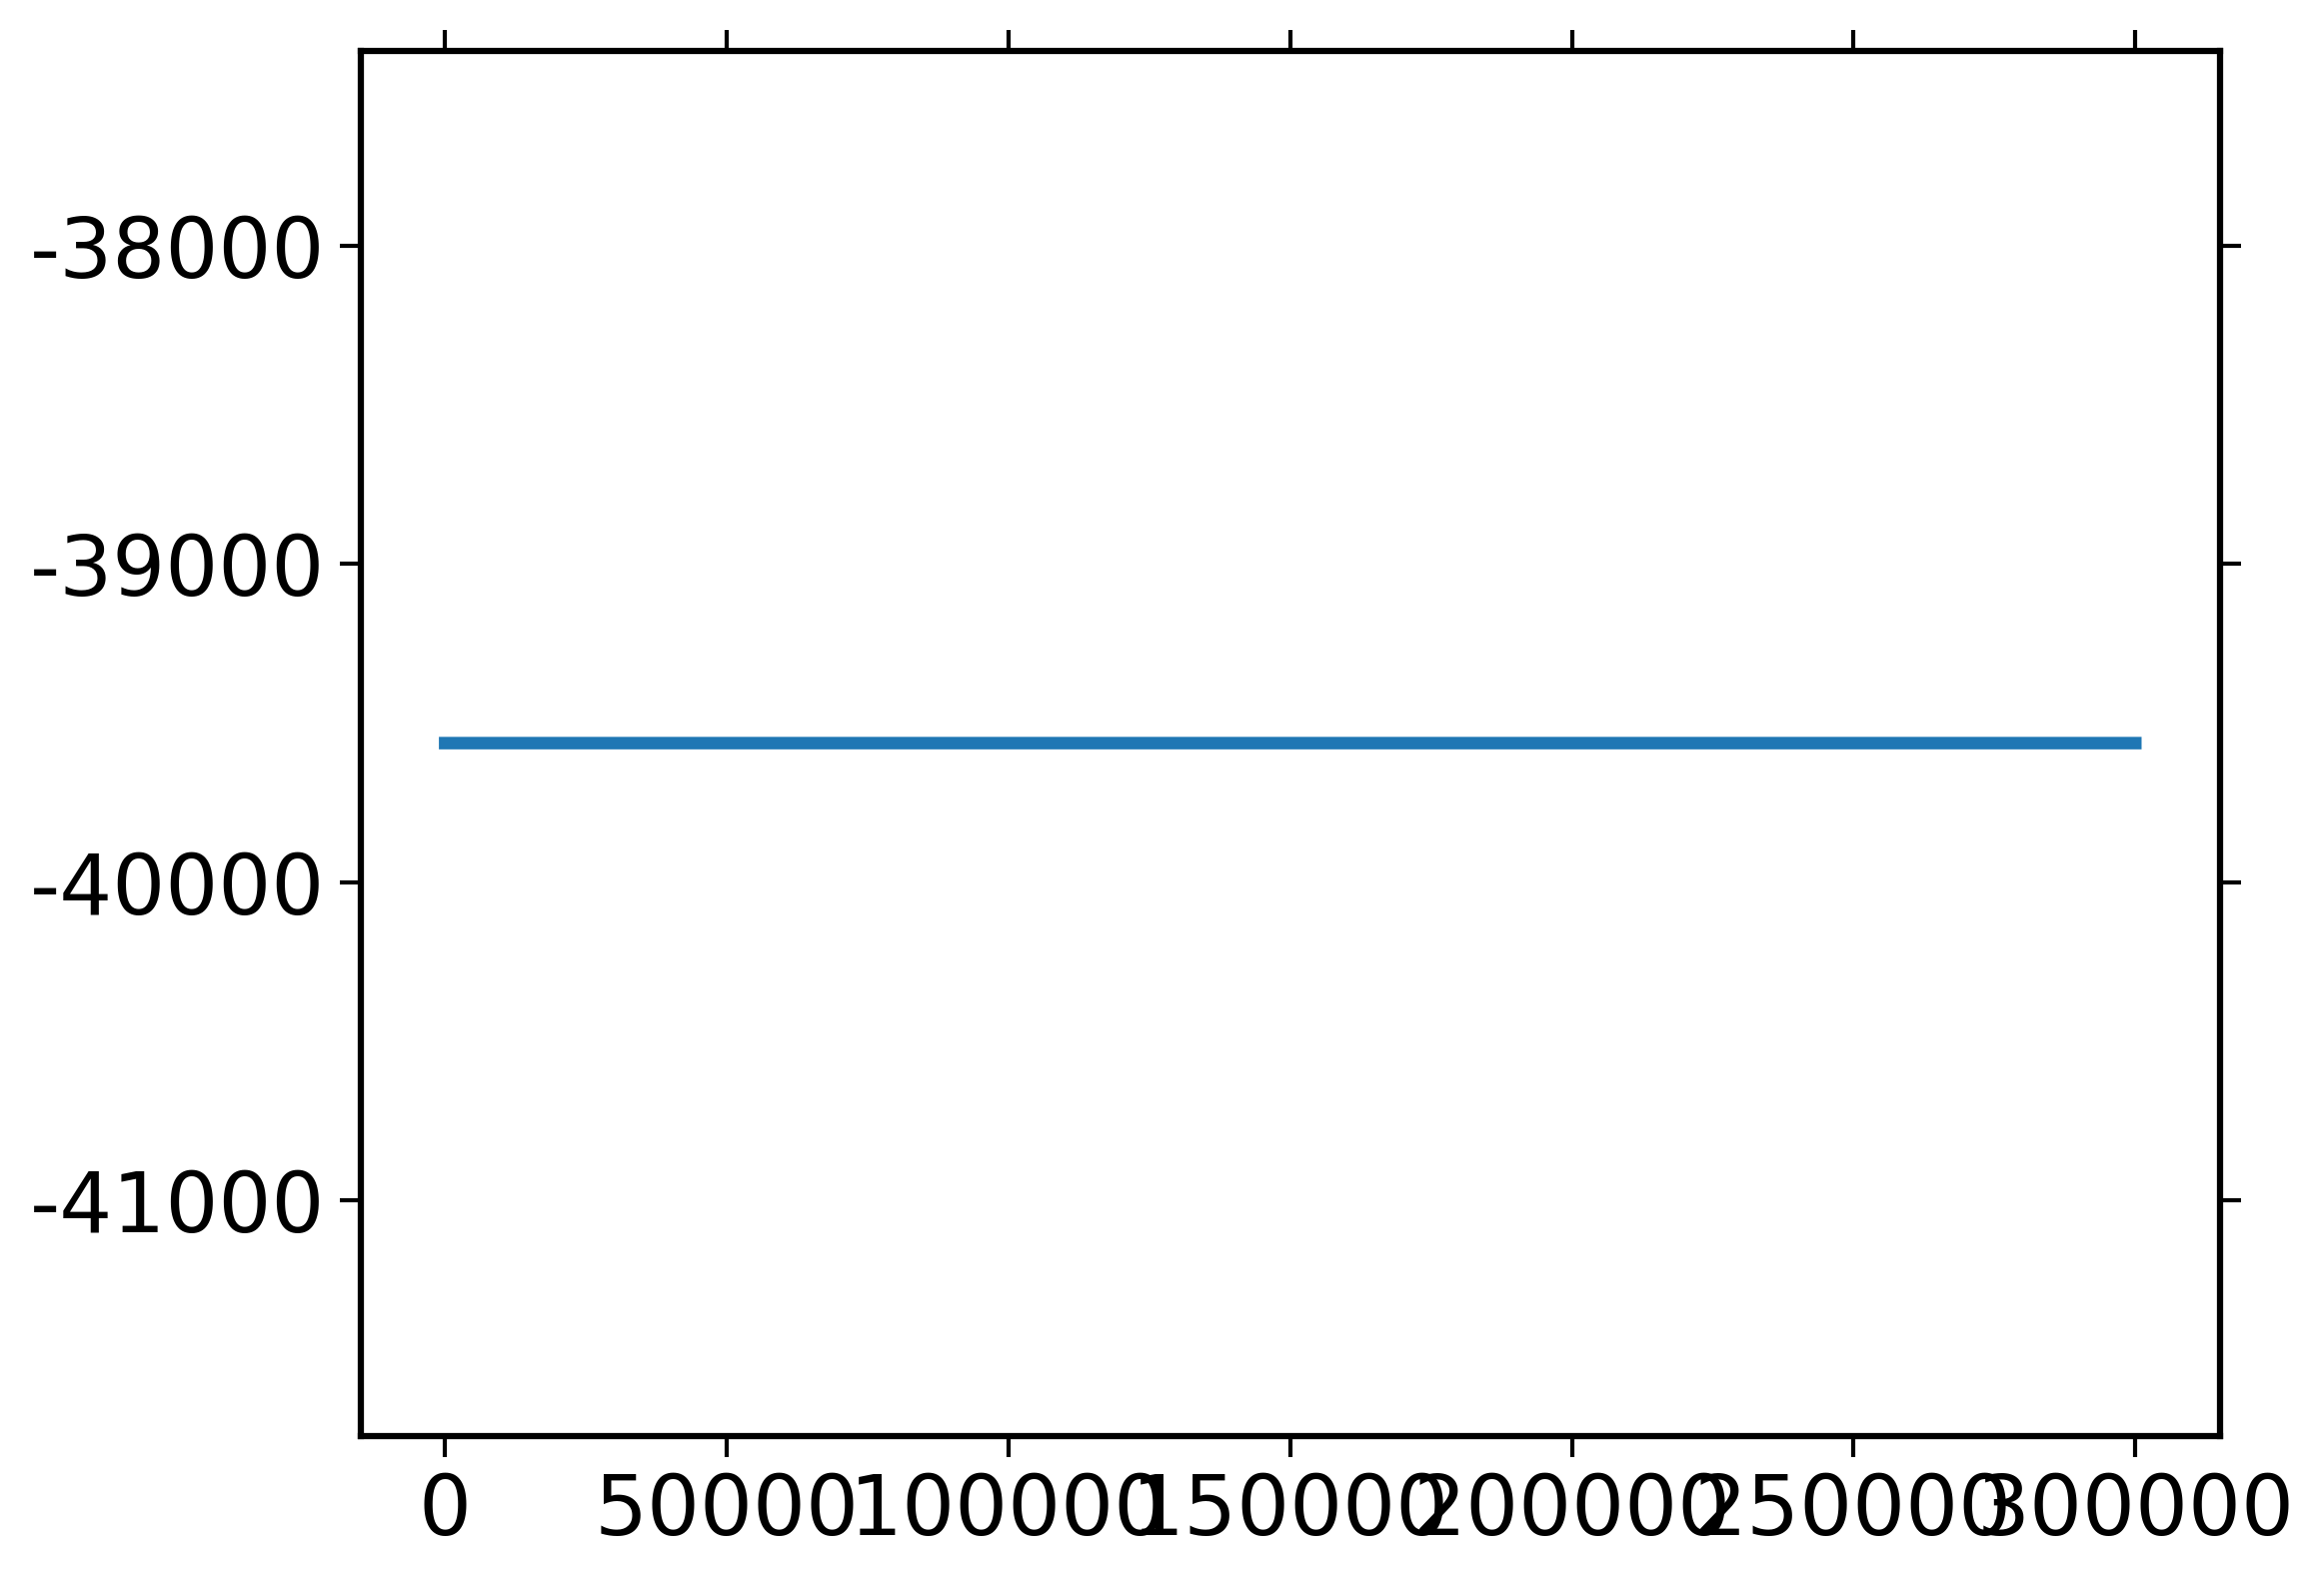

In [11]:
energy_dir = '/global/scratch/users/yychoi94/CaNaVP_gcMC/300Na1to3/data/-30.0_-3.98303_energy.npy'
energies = np.load(energy_dir)
plt.plot(energies)
print(energies[-1])

In [13]:
occu_dir = '/global/scratch/users/yychoi94/CaNaVP_gcMC/300Na1to3/data/-30.0_-3.98303_occupancy.npz'
occupancies = np.load(occu_dir)['o']
final_structure = ensemble.processor.structure_from_occupancy(occupancies[-1])
final_structure.sort()

In [20]:
final_structure.to('POSCAR', './300_Na1_POSCAR')

In [14]:
print(occupancies[-1])

[0 0 0 ... 1 1 1]


In [15]:
na_list = []
v4_list = []
for i, occu_decoded in enumerate(ensemble.processor.decode_occupancy(occupancies[-1])):
    if occu_decoded == v4:
        v4_list.append(i)
    if occu_decoded == na:
        na_list.append(i)

In [16]:
test_occu = deepcopy(occupancies[-1])
test_occu[300] = 0 # Change vac to Na

In [17]:
ensemble.processor.compute_feature_vector(test_occu) @ ensemble.processor.coefs

-39571.75062471628

In [18]:
ensemble.processor.compute_feature_vector(occupancies[-1]) @ ensemble.processor.coefs

-39563.29943683782

In [19]:
# To track change of energy of one flip, vac + V4+ --> Na+ + V3+
# Set change of vac --> Na+ at 300
energy_change_list = []
largest_change_list = []
for i in v4_list:
    energy = ensemble.processor.compute_feature_vector_change(occupancies[-1], [(300, 0), (i, 0)]) @ ensemble.processor.coefs
    energy_change_list.append(energy)
    if energy < -3.1:
        largest_change_list.append(i)

Text(0, 0.5, '$\\it\\mu$ of Na')

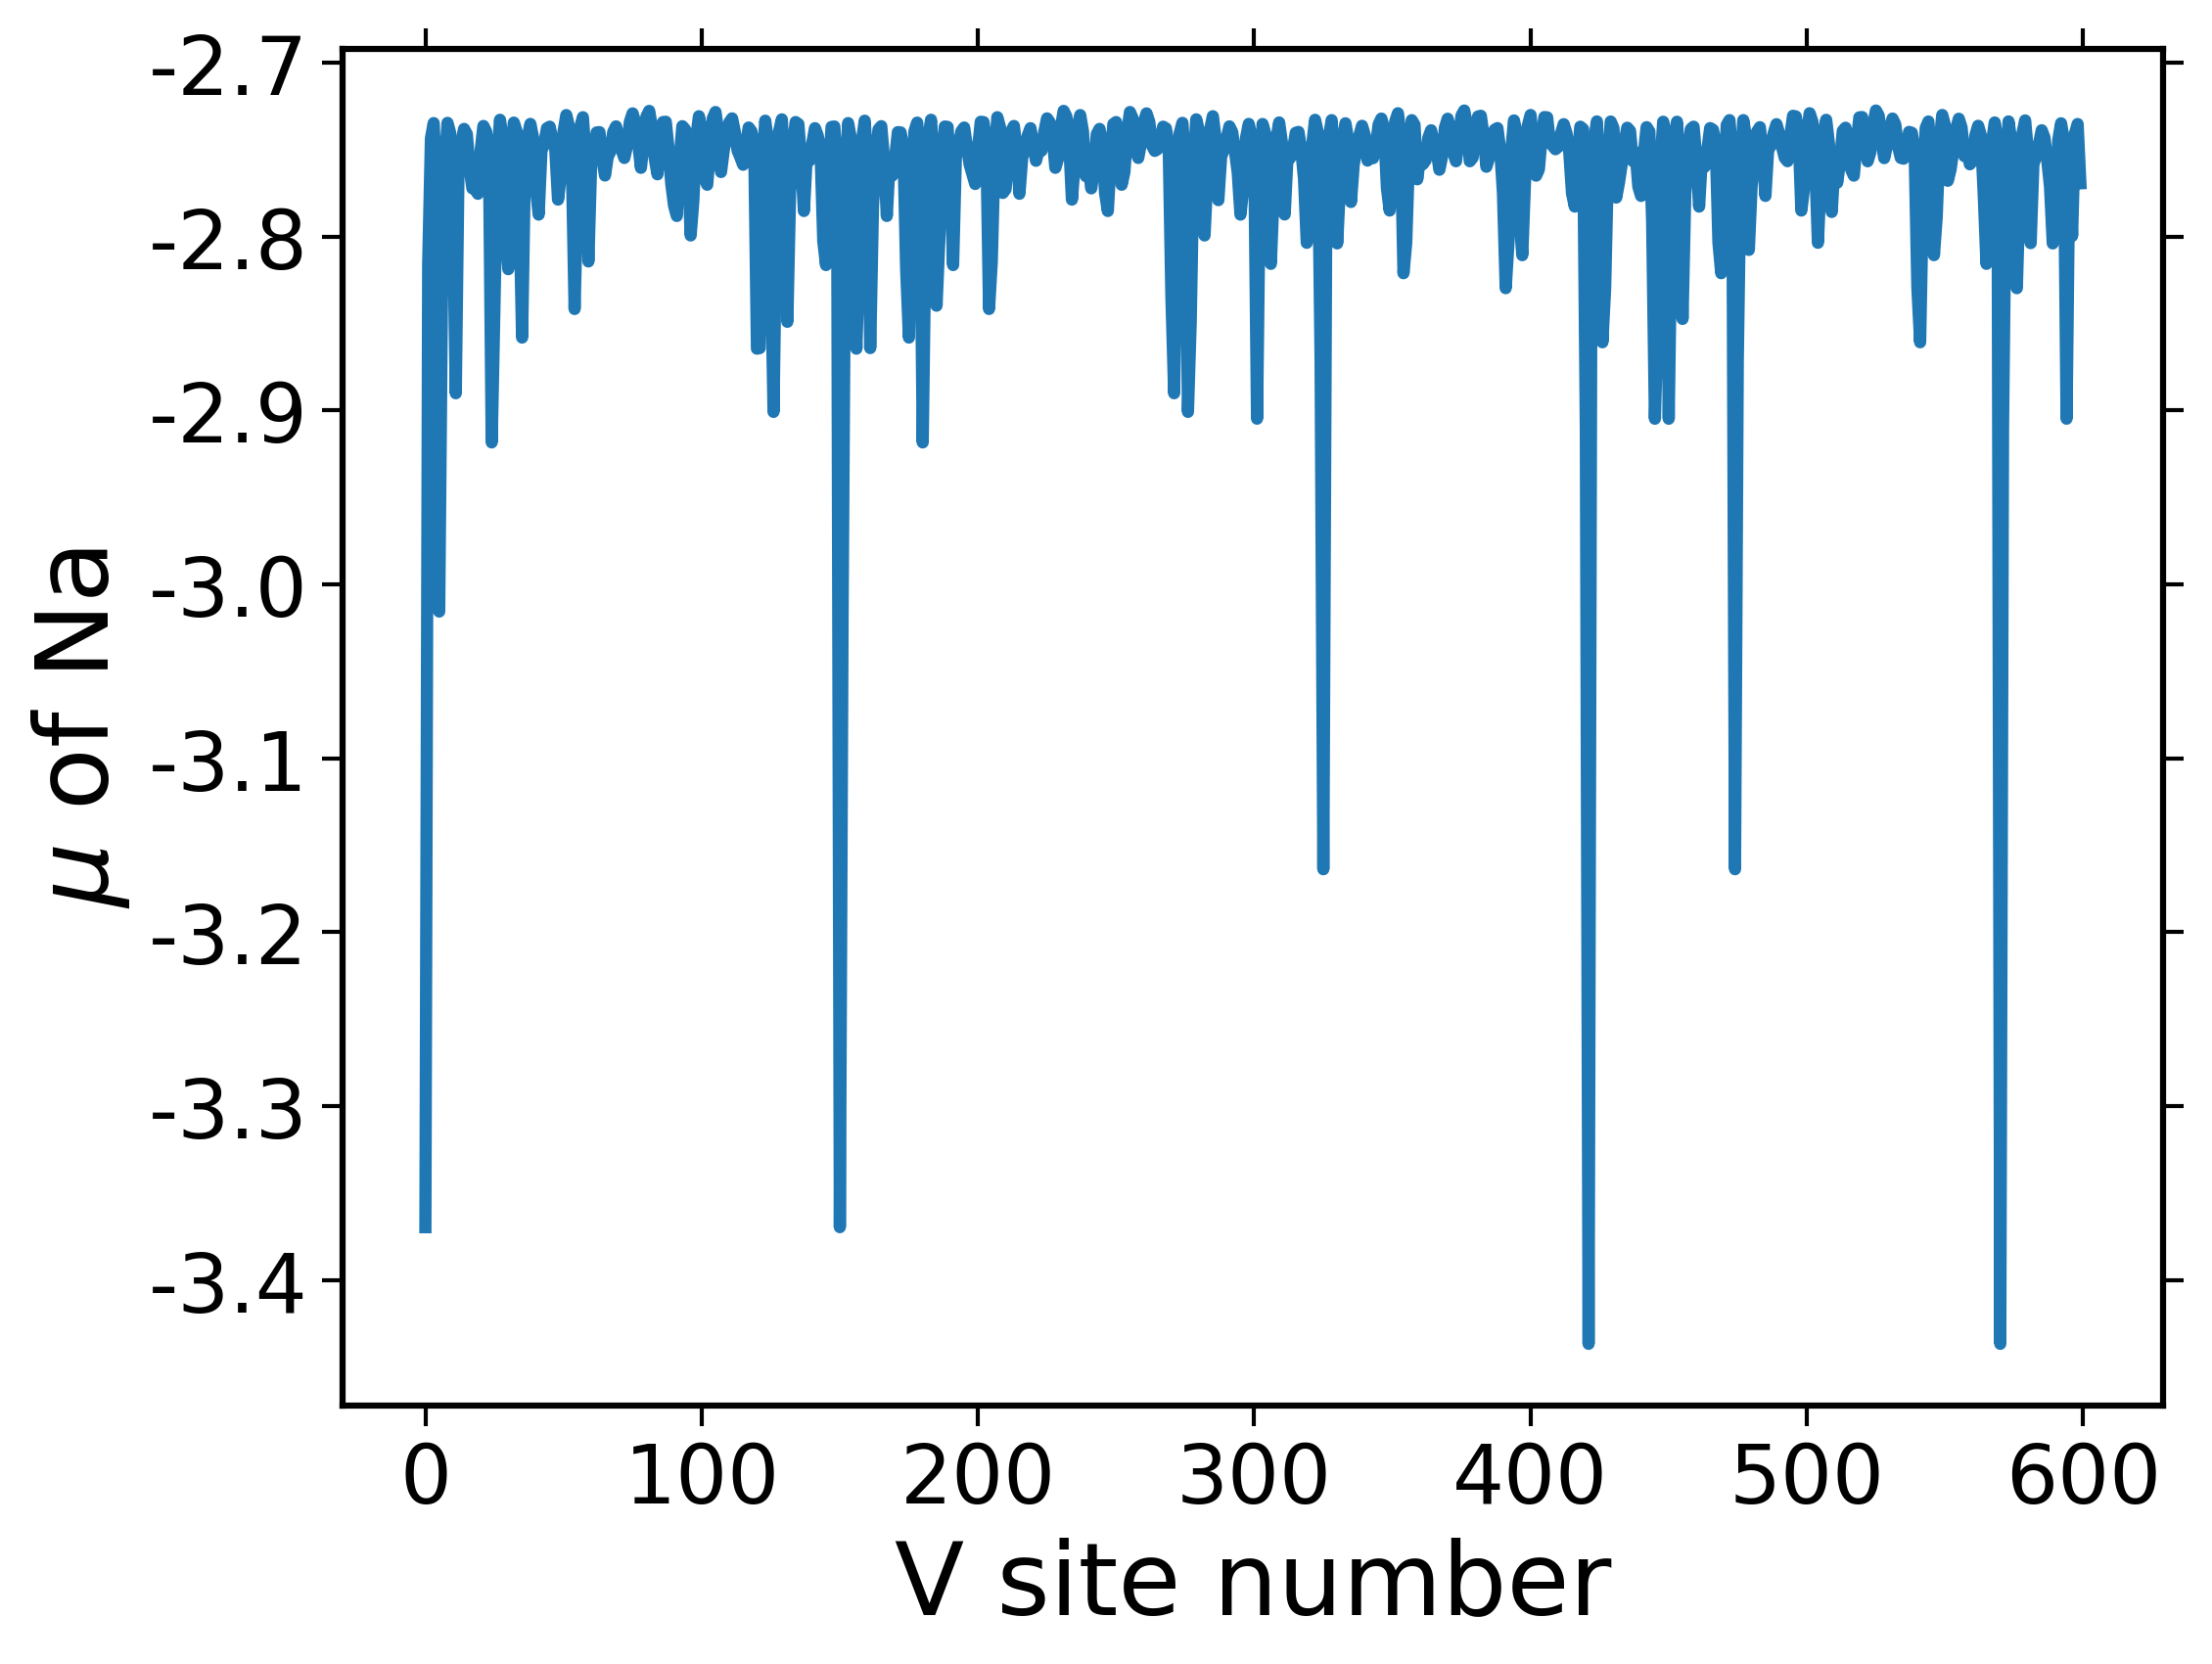

In [20]:
plt.plot(energy_change_list)
plt.xlabel("V site number")
plt.ylabel(r"$\it\mu$ of Na")

In [21]:
largest_change_list

[5700, 5850, 6025, 6121, 6174, 6270]

In [46]:
term_id = []
term_change = []
tot = 0
for i, j in enumerate(ensemble.processor.compute_feature_vector_change(occupancies[-1], [(300, 0), (5800, 0)])):
    change_per_term  = j * ensemble.processor.coefs[i]
    tot += change_per_term
    if not change_per_term == 0:
        term_id.append(i)
        term_change.append(change_per_term)

In [47]:
term_id_ref = []
term_change_ref = []
tot = 0
for i, j in enumerate(ensemble.processor.compute_feature_vector_change(occupancies[-1], [(300, 0), (5700, 0)])):
    change_per_term  = j * ensemble.processor.coefs[i]
    tot += change_per_term
    if not change_per_term == 0:
        term_id_ref.append(i)
        term_change_ref.append(change_per_term)

In [45]:
tot

-2.7385922815084376

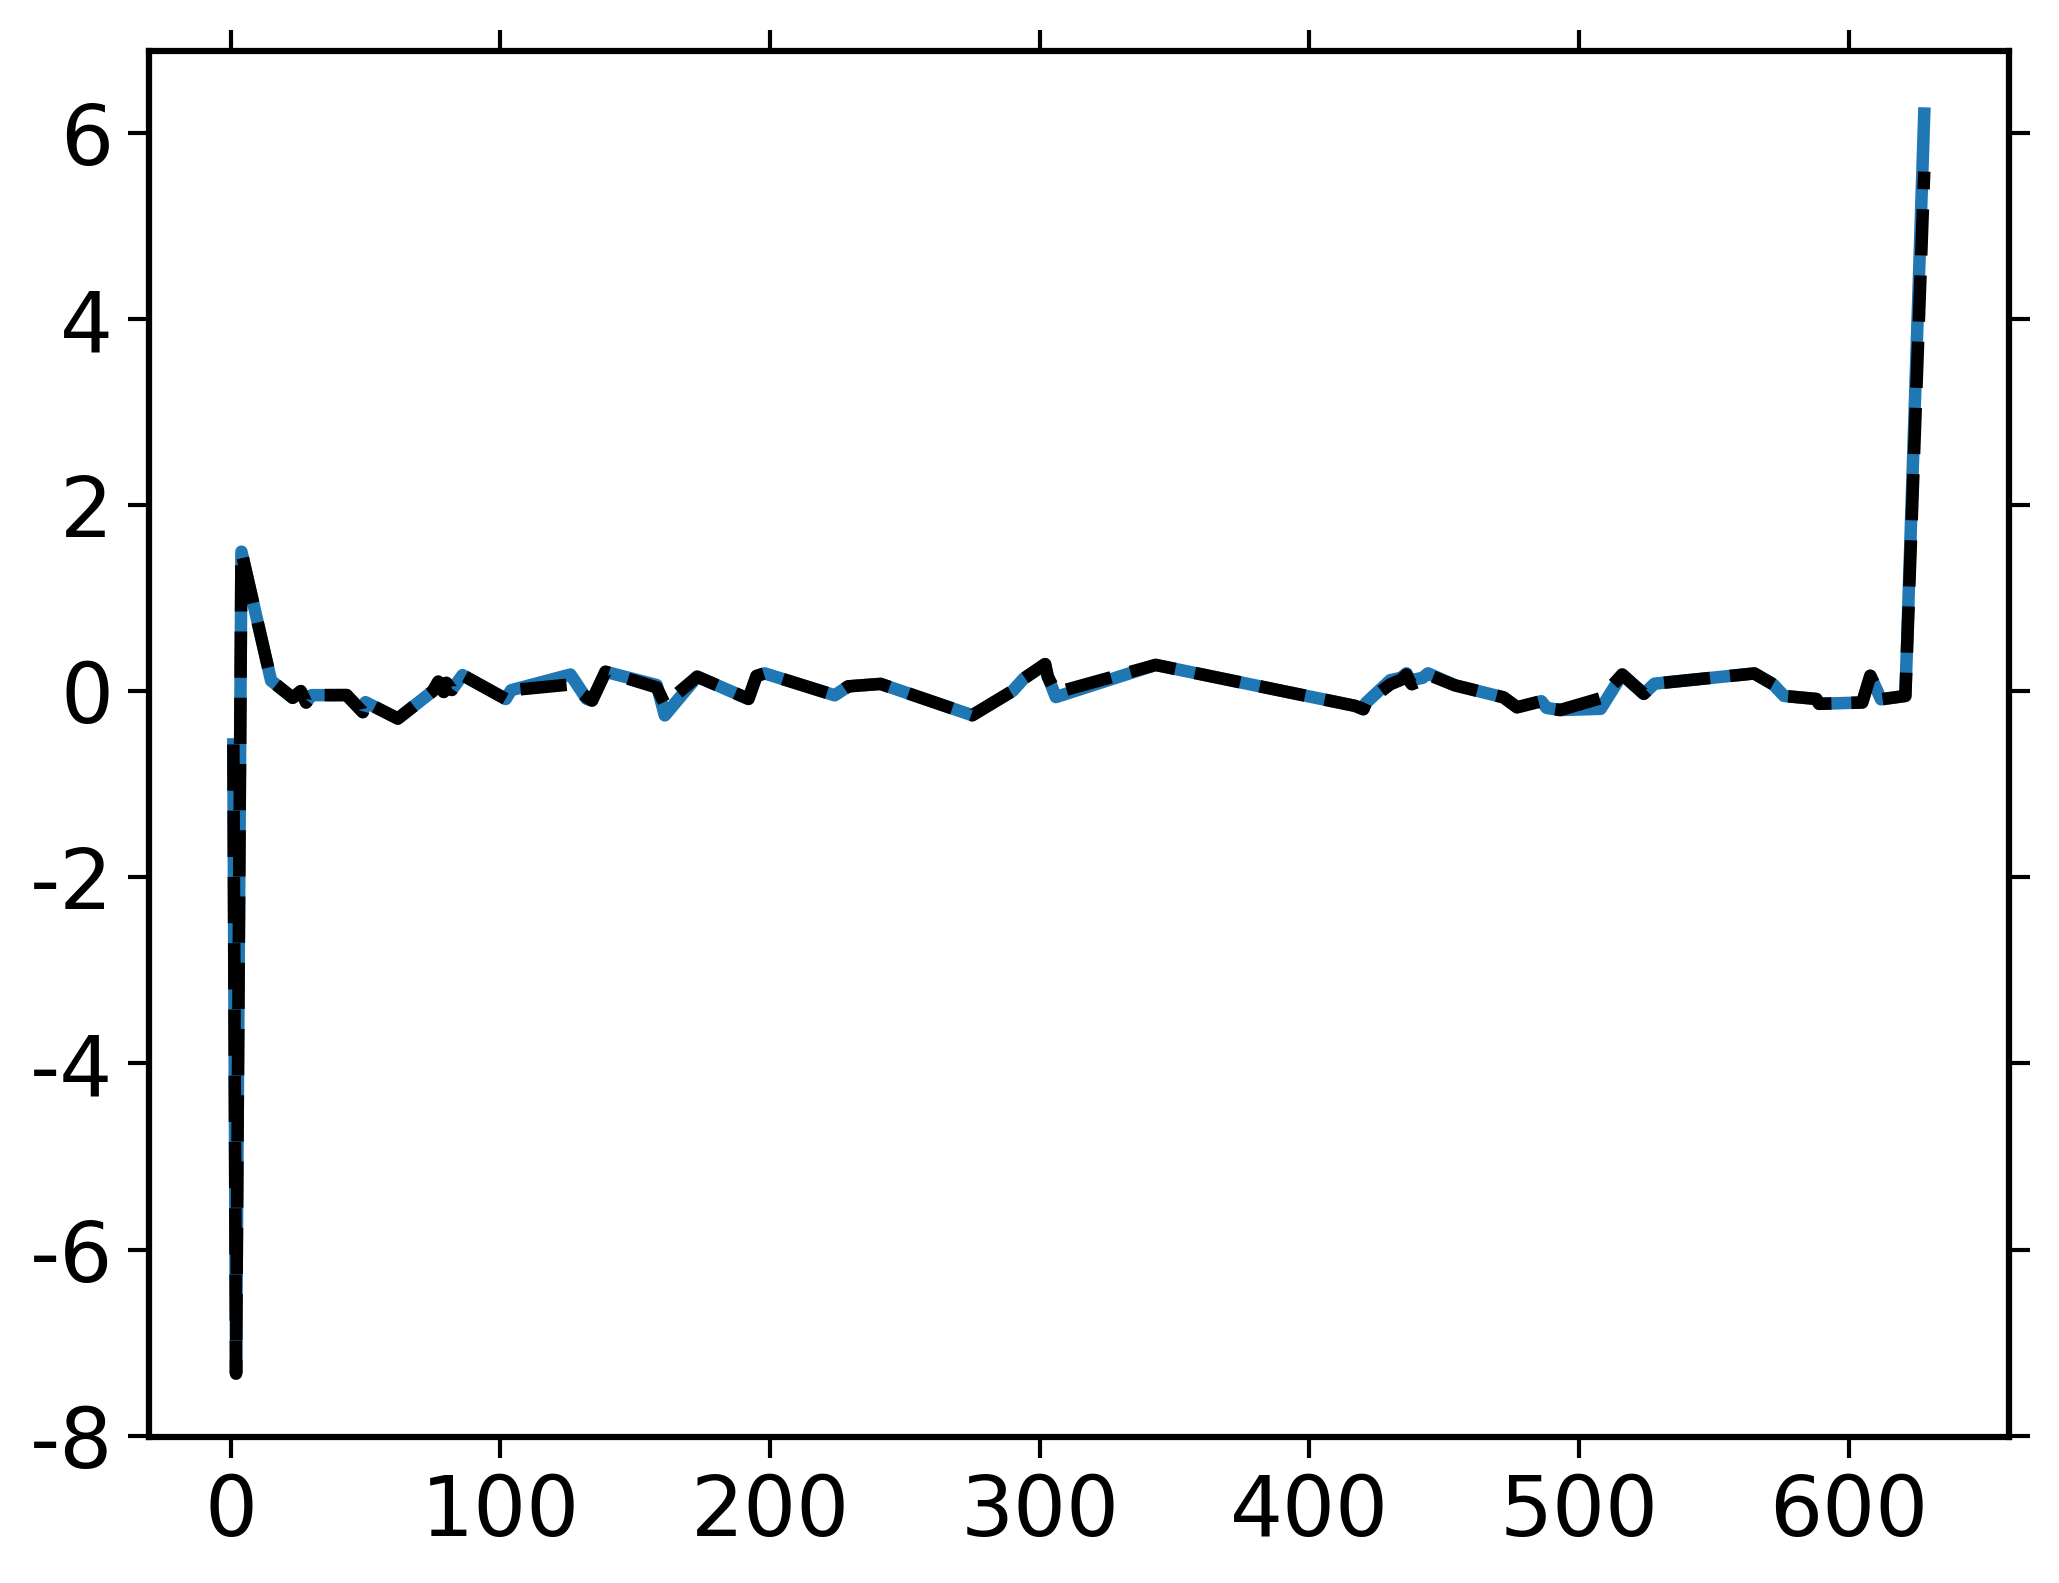

In [48]:
plt.plot(term_id, term_change)
plt.plot(term_id_ref, term_change_ref, color = 'black', linestyle='--')

In [49]:
term_change[-1]

6.2052658951787985

In [50]:
term_change_ref[-1]

5.58174544424073

In [51]:
np.array(term_change) - np.array(term_change_ref)

array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.10691, -0.01661,  0.     ,
        0.     ,  0.0261 , -0.12047,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     , -0.04827,  0.     ,  0.     ,
        0.     ,  0.     ,  0.04398,  0.02145,  0.01363,  0.01594,
        0.04398,  0.02145,  0.01363,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     , -0.11418,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.62352])

In [52]:
len(term_change)

71

In [56]:
ensemble.processor.active_site_spaces


(Ca2+0.33333333 Na+0.33333333 vacA0+0.33333333,
 V3+0.33333333 V4+0.33333333 V5+0.33333333 )

In [66]:
expansion.cluster_subspace.function_orbit_ids

array([  0,   1,   1,   2,   2,   3,   3,   4,   4,   4,   4,   5,   5,
         5,   5,   6,   6,   6,   6,   7,   7,   7,   7,   8,   8,   8,
         9,   9,   9,   9,  10,  10,  10,  10,  11,  11,  11,  12,  12,
        12,  12,  13,  13,  13,  14,  14,  14,  15,  15,  15,  15,  16,
        16,  16,  17,  17,  17,  17,  18,  18,  18,  18,  19,  19,  19,
        19,  20,  20,  20,  21,  21,  21,  21,  22,  22,  22,  22,  23,
        23,  23,  24,  24,  24,  24,  25,  25,  25,  25,  26,  26,  26,
        27,  27,  27,  27,  28,  28,  28,  29,  29,  29,  29,  30,  30,
        30,  30,  31,  31,  31,  31,  32,  32,  32,  32,  33,  33,  33,
        33,  34,  34,  34,  34,  35,  35,  35,  35,  36,  36,  36,  36,
        36,  36,  36,  36,  37,  37,  37,  37,  37,  37,  38,  38,  38,
        38,  38,  38,  38,  38,  39,  39,  39,  39,  39,  39,  39,  39,
        40,  40,  40,  40,  40,  40,  40,  40,  41,  41,  41,  41,  41,
        41,  41,  41,  42,  42,  42,  42,  42,  42,  42,  42,  4

In [62]:
expansion.cluster_subspace.orbits

[Orbit 1
 Multiplicity: 6     No. functions: 2     No. symmetry ops: 2   
 Function ids: [1, 2]
 Base Cluster:
   No. sites: 1   Diameter: 0.0000
   Centroid: (-7.1311, -2.7673, -5.4511) -> [0.1161, 0.3839, 0.7500]
   Site: vacA0+:0.333, Na+:0.333, Ca2+:0.333 (-7.1311, -2.7673, -5.4511) -> [0.1161, 0.3839, 0.7500],
 Orbit 2
 Multiplicity: 4     No. functions: 2     No. symmetry ops: 3   
 Function ids: [3, 4]
 Base Cluster:
   No. sites: 1   Diameter: 0.0000
   Centroid: (-8.7288, -5.0396, -6.8429) -> [0.3528, 0.3528, 0.9415]
   Site: V3+:0.333, V4+:0.333, V5+:0.333 (-8.7288, -5.0396, -6.8429) -> [0.3528, 0.3528, 0.9415],
 Orbit 3
 Multiplicity: 2     No. functions: 2     No. symmetry ops: 6   
 Function ids: [5, 6]
 Base Cluster:
   No. sites: 1   Diameter: 0.0000
   Centroid: (-8.7288, -5.0396, -3.6340) -> [0.5000, 0.5000, 0.5000]
   Site: vacA0+:0.333, Na+:0.333, Ca2+:0.333 (-8.7288, -5.0396, -3.6340) -> [0.5000, 0.5000, 0.5000],
 Orbit 4
 Multiplicity: 12    No. functions: 4     No